In [1]:
#%% Imports
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import cv2 as cv

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# %% Settings 
sns.set()

In [3]:
# %% Loading dataframe from new and old result
#df_new = pd.read_hdf('df_batch_0.hdf', key='df')
df_new = pd.read_hdf('df_new.hdf', key='df')
df_old = pd.read_hdf('../../data/testing_data/clement/old_combined.hdf', 'data')

In [7]:
# %% Names are different apparently so we need to rename them, only used for old stuff
df_old = df_old.rename(columns={'X (in pixel)': 'x', 'Y (in pixel)': 'y'}) #renaming columns
df_old = df_old[['frame', 'ID', 'x', 'y']]

In [9]:
# %% We need to match the right frame numbers
initial_frame = np.max([df_old['frame'].min(), df_new['frame'].min()])
final_frame = np.min([df_old['frame'].max(), df_new['frame'].max()])

df_old = df_old.query(f'{initial_frame} <= frame <= {final_frame}')[['frame', 'ID', 'x', 'y']]
df_new = df_new.query(f'{initial_frame} <= frame <= {final_frame}')

In [10]:
# %% Sorting
df_new = df_new.sort_values(by=['frame', 'ID'])
df_old = df_old.sort_values(by=['frame', 'ID'])

In [11]:
# %% Let's check if that worked
print(df_old['frame'].min(), df_old['frame'].max())
print(df_new['frame'].min(), df_new['frame'].max())

99 108051
99.0 108051.0


In [12]:
# %% We don't have the same number of flies due to Michaelf fuckup
n_flies_old = df_old.ID.unique().size
n_flies_new = df_new.ID.unique().size 

print(n_flies_new, n_flies_old)

40 40


230.5461484156959 51.61879502661797


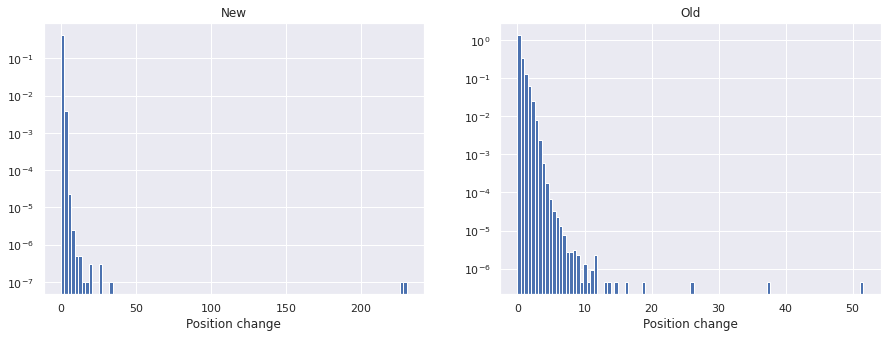

In [13]:
#%% Let's first study the trajectories themselves. They should be continuous, so the jump frame-to-frame should be small
change_new = np.sum(np.diff(df_new[['x', 'y']].to_numpy().reshape(-1, n_flies_new, 2), axis=0)**2, axis=2)**(1/2)
change_old = np.sum(np.diff(df_old[['x', 'y']].to_numpy().reshape(-1, n_flies_old, 2), axis=0)**2, axis=2)**(1/2)

print(np.max(change_new), np.max(change_old))

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(change_new.flatten(), bins=100, log=True, density=True)
plt.title('New')
plt.xlabel('Position change')

plt.subplot(122)
plt.hist(change_old.flatten(), bins=100, log=True, density=True)
plt.title('Old')
plt.xlabel('Position change')

plt.show()

In [25]:
np.where(change_new == np.max(change_new))

(array([5309]), array([37]))

In [14]:
# %% Internally the trajectories seem good; no weird jumps. 
# %% Now we calculaaaaiate the distance between them to get a match 
# %% We already sorted them the same way so we can simply reshape. We do need to subtract the initial position  though 
df_new_offset = df_new[['x', 'y']].to_numpy().reshape(-1, n_flies_new, 2)
df_new_offset -= df_new_offset[0, :, :]

df_old_offset = df_old[['x', 'y']].to_numpy().reshape(-1, n_flies_old, 2)
df_old_offset -= df_old_offset[0, :, :]

distances = np.sum((np.expand_dims(df_old_offset, 1) - np.expand_dims(df_new_offset, 2))**2, axis=-1)**(1/2)

Text(0.5, 1.0, 'Max distance')

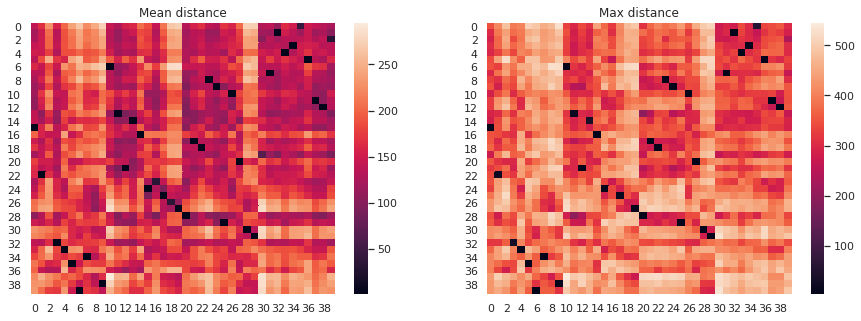

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.heatmap(np.mean(distances, axis=0))
plt.title('Mean distance')
plt.subplot(122)
sns.heatmap(np.max(distances, axis=0))
plt.title('Max distance')

In [16]:
max_mean_dist = np.stack([np.min(np.max(distances, axis=0), axis=1), np.min(np.mean(distances, axis=0), axis=1)], axis=1)
print(max_mean_dist)

[[ 57.33968013  43.19658469]
 [  5.01520629   0.93725966]
 [239.14516176  32.59018387]
 [  8.91111278   1.04618281]
 [  6.75504457   0.70938804]
 [  5.29178644   0.91595934]
 [  6.22832762   0.72722849]
 [  4.83390981   0.83154649]
 [  3.87002755   1.02247144]
 [  4.13314258   0.90507029]
 [  6.45606001   1.1634838 ]
 [  4.3932481    1.73449278]
 [  3.78728907   0.63428368]
 [ 16.90933045   0.97218724]
 [ 37.8092949    0.54212954]
 [  9.12133924   3.0069616 ]
 [  4.60836925   0.75738288]
 [  3.75776508   0.60233245]
 [  4.73943998   0.67728515]
 [264.42724594  66.4507618 ]
 [  4.33663725   0.62325352]
 [  5.81530311   0.60900867]
 [ 20.57499898   0.70892277]
 [272.48238768  33.2176498 ]
 [  8.16589723   0.77930875]
 [ 16.93572485   0.68482651]
 [272.74256823  33.00248565]
 [ 10.45972824   2.30689411]
 [  3.16719984   0.58498623]
 [  4.62988534   0.76857816]
 [  4.12886497   0.53482007]
 [  3.62432647   0.63179671]
 [ 31.66493546   0.78274462]
 [  9.16572521   1.27679076]
 [  6.67711987

So there are some discrepancies, mostly among 7, 13 and 17. We have one unmatched, which, given the mean distance is probably 7. That means 13 and 17 probably have an inversion somewhere? Let's first match the indices so we can compare.

In [17]:
new_idx, old_idx = linear_sum_assignment(np.mean(distances, axis=0))

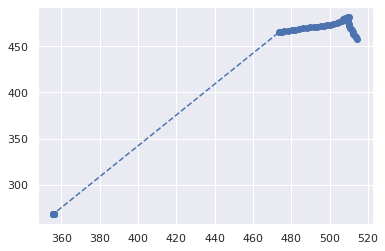

In [36]:
ID = 37
plt.plot(df_new.query(f'ID == {ID} and 5450>frame>5400')[['x']], df_new.query(f'ID == {ID} and 5450>frame>5400')[['y']], 'o--')



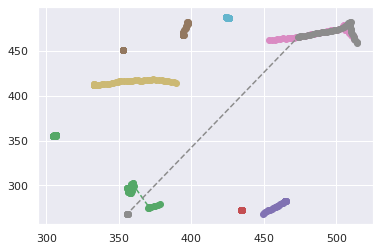

In [46]:
arena = 0
for ID in np.arange(40):
    plt.plot(df_new.query(f'ID == {ID} and 5450>frame>5400 and arena == {arena}')[['x']], df_new.query(f'ID == {ID} and 5450>frame>5400 and arena == {arena}')[['y']], 'o--')



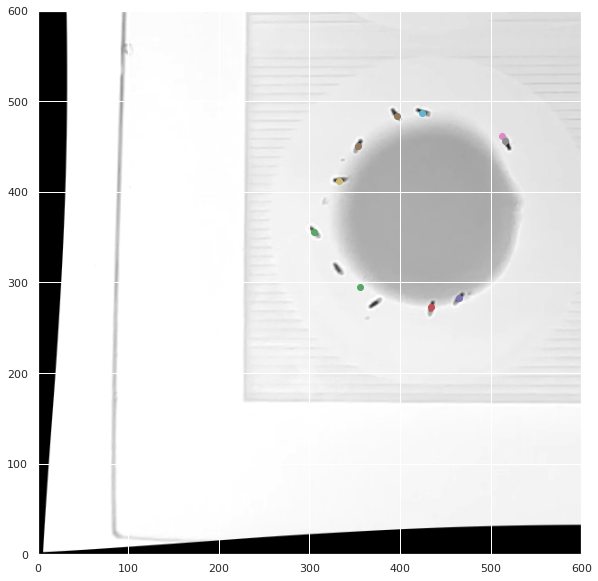

In [75]:
def construct_undistort_map(image_size, folder):
    """ Construct openCV undistort undistort mapping. Make sure files as named below are the supplied folder.
    Returns a function which takes in image and returns the undistorted image."""
    mtx = np.load(join(folder, "mtx_file.npy"))
    dist = np.load(join(folder, "dist_file.npy"))
    newcameramtx = np.load(join(folder, "newcameramtx_file.npy"))

    mapping = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, image_size, 5)
    return mapping

In [76]:
def preprocessing(image, mapping, mask):
    """Preprocesses image to make it ready for kmeans."""
    processed_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    processed_image = cv.remap(processed_image, *mapping, cv.INTER_LINEAR)
    processed_image[~mask] = 255
    return processed_image

In [84]:
# Making mask
from os.path import join
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
image_size = (
        int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
    )
mapping = construct_undistort_map(image_size, mapping_folder)
image = lambda img: preprocessing(img, mapping=mapping, mask=np.ones(image_size, dtype=bool).T)

In [118]:
# Making mask
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/clement/seq_1.mp4"
capture = cv.VideoCapture(movie_path)
frame = 5408
capture.set(cv.CAP_PROP_POS_FRAMES, frame)

img = image(capture.read()[1])

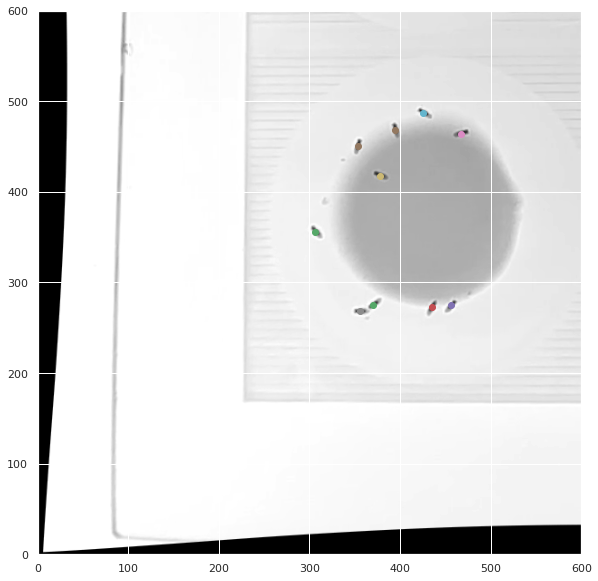

In [119]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.xlim([0, 600])
plt.ylim([0, 600])
for ID in np.arange(40):
    plt.plot(df_new.query(f'ID == {ID} and frame == {frame}')[['x']], df_new.query(f'ID == {ID} and frame == {frame}')[['y']], 'o')



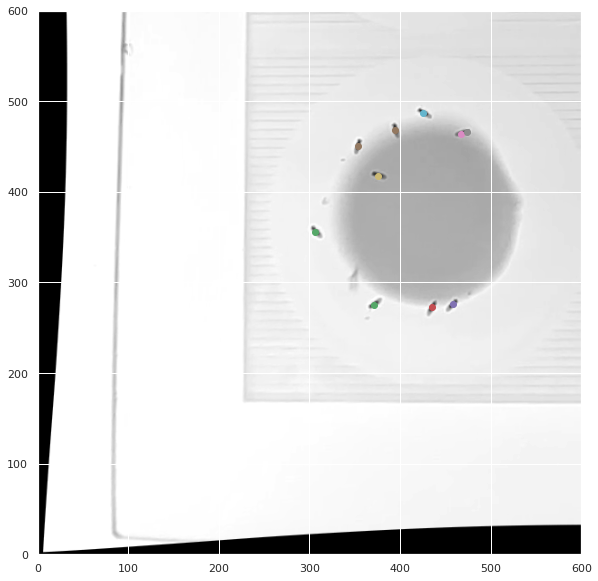

In [120]:
# Making mask
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/clement/seq_1.mp4"
capture = cv.VideoCapture(movie_path)
frame = 5409
capture.set(cv.CAP_PROP_POS_FRAMES, frame)

img = image(capture.read()[1])
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.xlim([0, 600])
plt.ylim([0, 600])
for ID in np.arange(40):
    plt.plot(df_new.query(f'ID == {ID} and frame == {frame}')[['x']], df_new.query(f'ID == {ID} and frame == {frame}')[['y']], 'o')



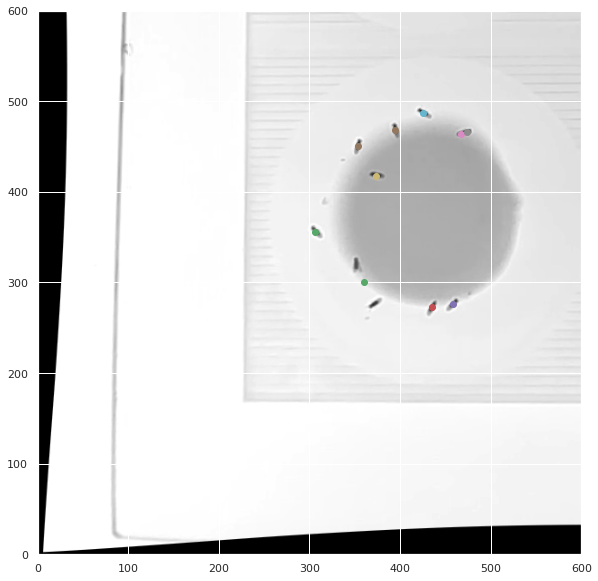

In [121]:
# Making mask
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/clement/seq_1.mp4"
capture = cv.VideoCapture(movie_path)
frame = 5410
capture.set(cv.CAP_PROP_POS_FRAMES, frame)

img = image(capture.read()[1])
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.xlim([0, 600])
plt.ylim([0, 600])
for ID in np.arange(40):
    plt.plot(df_new.query(f'ID == {ID} and frame == {frame}')[['x']], df_new.query(f'ID == {ID} and frame == {frame}')[['y']], 'o')



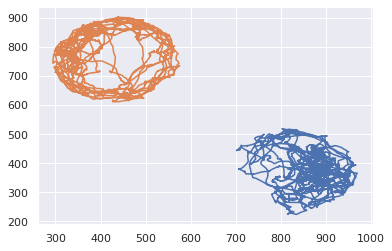

In [18]:
#%% Let's see if they're in the same quadrant
ID = 13
plt.plot(df_new.query(f'ID == {ID}')[['x']], df_new.query(f'ID == {ID}')[['y']])
ID = 17
plt.plot(df_new.query(f'ID == {ID}')[['x']], df_new.query(f'ID == {ID}')[['y']])

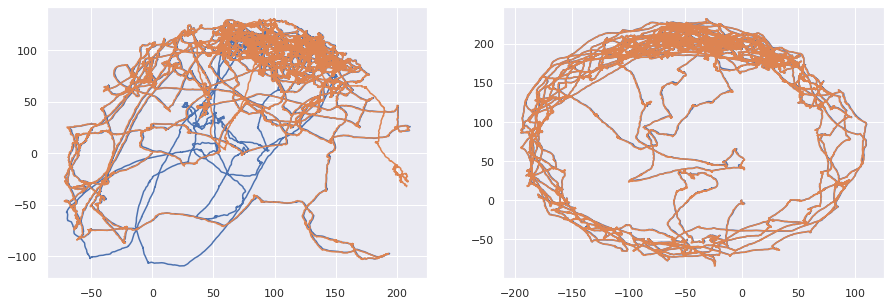

In [19]:
# %% Now let's plot them with Nicolas' result
plt.figure(figsize=(15, 5))
plt.subplot(121)
new_ID = 11
old_ID = old_idx[new_idx==new_ID]
plt.plot(df_new_offset[:, new_ID, 0], df_new_offset[:, new_ID, 1])
plt.plot(df_old_offset[:, old_ID, 0], df_old_offset[:, old_ID, 1])

plt.subplot(122)
new_ID = 17
old_ID = old_idx[new_idx==new_ID]
plt.plot(df_new_offset[:, new_ID, 0], df_new_offset[:, new_ID, 1])
plt.plot(df_old_offset[:, old_ID, 0], df_old_offset[:, old_ID, 1])

Text(0.5, 1.0, 'Distance in position between old and new approach')

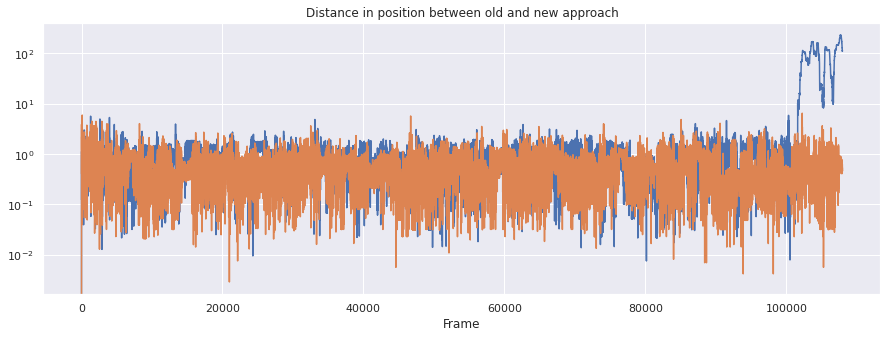

In [24]:
# %% And the distance in time between them
plt.figure(figsize=(15, 5))
new_ID = 11
old_ID = old_idx[new_idx==new_ID]
plt.semilogy(distances[:, new_ID, old_ID])
new_ID = 17
old_ID = old_idx[new_idx==new_ID]

plt.semilogy(distances[:, new_ID, old_ID])
plt.xlabel('Frame')
plt.title('Distance in position between old and new approach')

So them jumping at the same time is definitely an inversion. Now to figure it where it happens and see who's right.

In [21]:
old_idx[new_idx==13].item()

25

In [22]:
# %% The inversion happens after 100000, let's isolate that and the flies
inversion_point = 100000
new_flies = df_new_offset[inversion_point:, [13, 17], :]
old_flies = df_old_offset[inversion_point:, [old_idx[new_idx==13].item(), old_idx[new_idx==17].item()], :]


Text(0.5, 1.0, 'Fly 1')

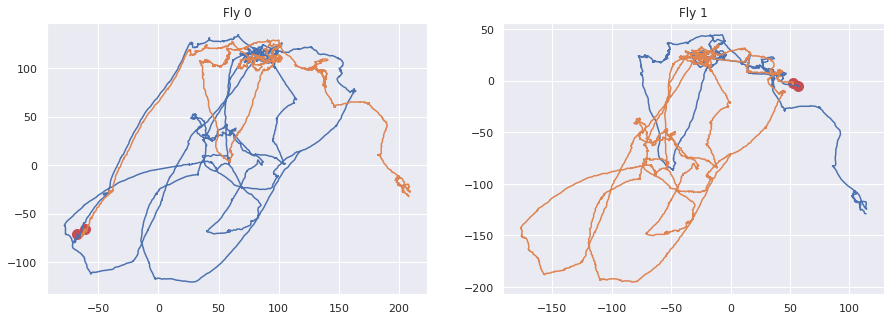

In [18]:
# %% Now let's plot them with Nicolas' result
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot()
plt.plot(new_flies[:, 0, 0], new_flies[:, 0, 1])
plt.plot(old_flies[:, 0, 0], old_flies[:, 0, 1])
plt.scatter(new_flies[0, 0, 0], new_flies[0, 0, 1], color='r', marker='o', s=100)
plt.scatter(old_flies[0, 0, 0], old_flies[0, 0, 1], color='r', marker='o', s=100)
plt.title('Fly 0')


plt.subplot(122)
plt.plot(new_flies[:, 1, 0], new_flies[:, 1, 1])
plt.plot(old_flies[:, 1, 0], old_flies[:, 1, 1])
plt.scatter(new_flies[0, 1, 0], new_flies[0, 1, 1], color='r', marker='o', s=100)
plt.scatter(old_flies[0, 1, 0], old_flies[0, 1, 1], color='r', marker='o', s=100)
plt.title('Fly 1')

In [35]:
# %% Let's load the data through opencv
capture = cv.VideoCapture('../../data/testing_data/4arenas/seq_1.mp4')

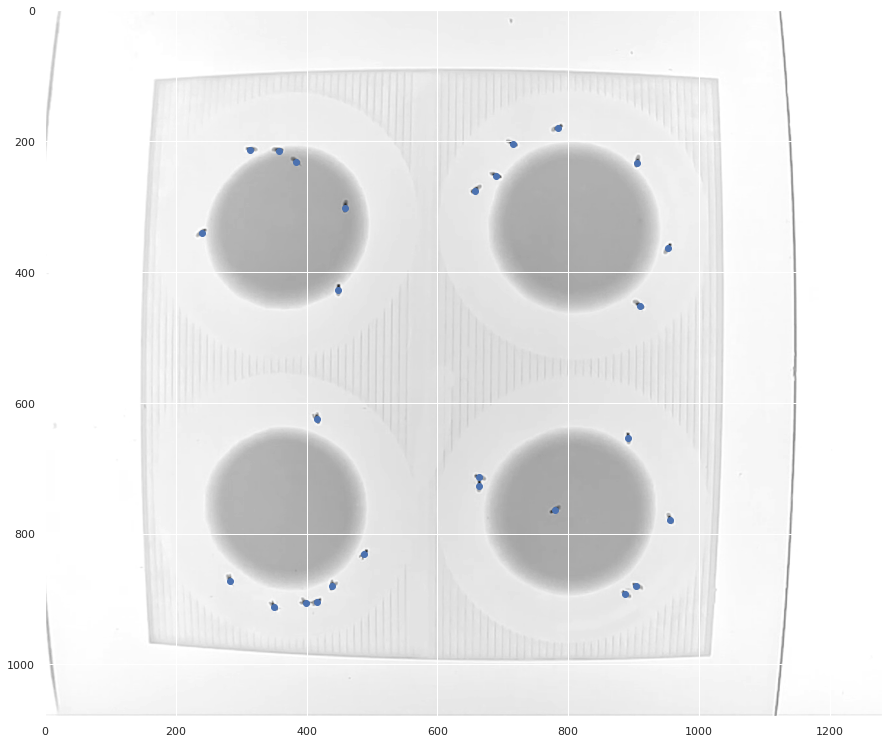

In [37]:
frame = inversion_point
capture.set(1, frame)
img = cv.cvtColor(capture.read()[1], cv.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')



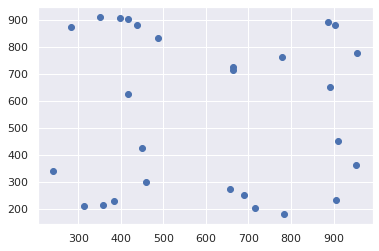

In [38]:
plt.scatter(df_new.query(f'frame == {frame}')['x'], df_new.query(f'frame == {frame}')['y'])

In [ ]:
length = 30
ini = inversion_point

    plt.plot(df_new.query(f'(ID == {ID}) and (ini-length < frame <= ini)')['x'], df_new.query(f'ID == {ID}')['y'])

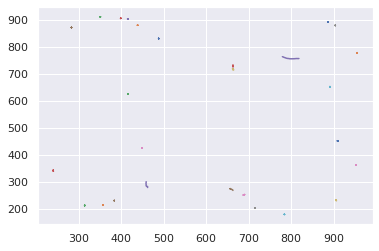

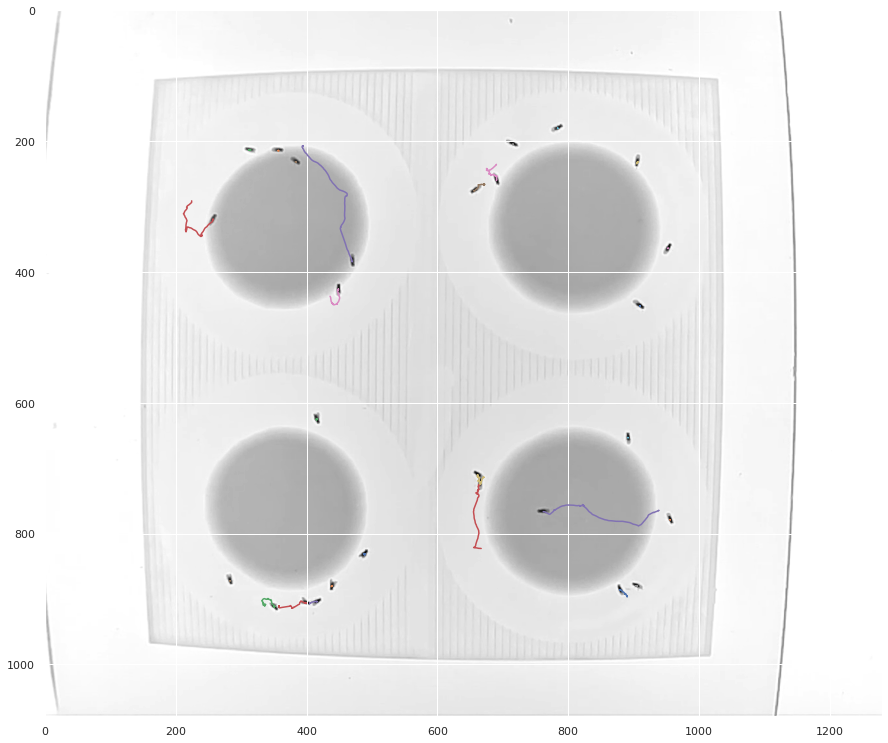

In [45]:
frame = inversion_point + 100
length = 30 * 10
capture.set(1, frame)
img = cv.cvtColor(capture.read()[1], cv.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')
for ID in np.arange(27):
    local_df = df_new.query(f'(ID == {ID}) and ({frame}-{length} < frame <= {frame})')
    plt.plot(local_df.x, local_df.y) 
    